# Exploratory Data Analysis : 'My Favorites Comics/Comedian's Youtube Channel '

## Obtain the dataset using Youtube API 

### Import Importan Libraries

In [306]:
from googleapiclient.discovery import build
import pandas as pd
from dateutil import parser
import numpy as np
import isodate
import math
from datetime import datetime, timedelta
import pytz

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set(style = 'whitegrid', context = 'poster', rc={"font.size":12,"axes.titlesize":36,"axes.labelsize":28})

### Data Creation

In [324]:
api_key = #Your API key 

channel_ids = ['UCreIaKE6DB7nKGgbISPSBmQ', # Abdel Achrian
               'UC6G_mVvDad8Px8E5g-V7eFQ', # Agak Laen
               'UCaiXkQ965Z23fv1qU5uz7rw', # Ananta Rispo
               'UCh1SzxJAH9B5nZDYYa42UqQ', # Pandji Pragiwaksono
               'UCM_fA7_3yKw7otJZZe3L8Uw', # Plus 26
               'UC4MbJ66pRUSdvFqJPOE3kew', # Rigen Rakelna
               'UCPgNw-DiG28-c3arK-AhSHw', # Ridwan Remin
               'UCHTMgayeb5SQwfNIxf-QFTw', # Soleh Solihun
               'UCzRxkmSKHlNOMNiJRG275Ow', # Tretan Muslim
               'UCviJm47ZvP4yagK9p70tK4A', # Uus 
              ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [144]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    return pd.DataFrame(all_video_info)

### Get Channel Statistics

In [328]:
chan_df = get_channel_stats(youtube, channel_ids)
chan_df

,channelName,subscribers,views,totalVideos,playlistId
0,Plus26,379000,44969656,65,UUM_fA7_3yKw7otJZZe3L8Uw
1,RIGEN RAKELNA,183000,13230928,112,UU4MbJ66pRUSdvFqJPOE3kew
2,Ananta Rispo,144000,28892235,178,UUaiXkQ965Z23fv1qU5uz7rw
3,Uus Kamukita,1370000,147858684,261,UUviJm47ZvP4yagK9p70tK4A
4,Abdel Achrian,685000,140451030,1309,UUreIaKE6DB7nKGgbISPSBmQ
5,Ridwan Remin,123000,26384533,208,UUPgNw-DiG28-c3arK-AhSHw
6,Agak Laen Official,273000,28099193,69,UU6G_mVvDad8Px8E5g-V7eFQ
7,Pandji Pragiwaksono,1150000,224562763,1530,UUh1SzxJAH9B5nZDYYa42UqQ
8,Tretan Universe,1460000,204994093,344,UUzRxkmSKHlNOMNiJRG275Ow
9,Soleh Solihun,356000,62394840,311,UUHTMgayeb5SQwfNIxf-QFTw


### Get Video Statistics for all Channels

In [145]:
video_df = pd.DataFrame()

for a in chan_df['channelName'].unique():
    print('Getting video information from ' + a + ' channel')
    playlist_id = chan_df.loc[chan_df['channelName'] == a, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    video_data = get_video_details(youtube, video_ids)
    video_df = pd.concat([video_df,video_data])

Getting video information from Abdel Achrian channel
Getting video information from Soleh Solihun channel
Getting video information from Uus Kamukita channel
Getting video information from Ananta Rispo channel
Getting video information from Plus26 channel
Getting video information from RIGEN RAKELNA channel
Getting video information from Ridwan Remin channel
Getting video information from Tretan Universe channel
Getting video information from Pandji Pragiwaksono channel
Getting video information from Agak Laen Official channel


In [146]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,hG2ZxFDJSeI,Abdel Achrian,#short #abdel #wawancanda MEMES PRAMESWARI 🔥🔥🔥,#abdel #wawancanda \n\nFull Video : https://yo...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-15T05:00:18Z,809,15,None,0,PT38S,hd,false
1,nH_l7VjXrQM,Abdel Achrian,"HOHO HIHI - CENTANG BIRU, KEBAYA MERAH (EPISOD...",#abdel #gilbhas #hohohihi\n\nSupport hoho hihi...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-14T11:00:36Z,15611,466,None,120,PT1H46M50S,hd,false
2,KkR5buqovvs,Abdel Achrian,#short #abdel #wawancanda ILHAM SETIYADI 🔥🔥🔥,#abdel #wawancanda \n\nFull Video : https://yo...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-14T05:00:09Z,1626,36,None,0,PT51S,hd,false
3,SkRsA89Keic,Abdel Achrian,NGABDUR - MAMAT DAPET KURSI,#abdel #abdur #ngabdur \n\nSupport hoho hihi ⬇...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-13T11:00:19Z,40174,969,None,164,PT1H8M17S,hd,false
4,SZJLss54UCw,Abdel Achrian,#short #abdel #wawancanda TEGUH KUBILER 🔥🔥🔥,#abdel #wawancanda \n\nFull Video : https://yo...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-13T10:00:17Z,2003,49,None,0,PT49S,hd,false


## Preprocessing Channel Data

In [330]:
columns = ['subscribers','views','totalVideos']
chan_df[columns] = chan_df[columns].apply(pd.to_numeric, errors='coerce', axis=1)

## Preprocessing Video data

### Check empty values

In [270]:
data = video_df

In [271]:
data.isnull().any()

video_id            False
channelTitle        False
title               False
description         False
tags                 True
publishedAt         False
viewCount           False
likeCount            True
favouriteCount       True
commentCount         True
duration            False
definition          False
caption             False
durationMins        False
year                False
hour                False
publishedDayName    False
dtype: bool

### Check data types of each column

In [272]:
data.dtypes

video_id                                  object
channelTitle                              object
title                                     object
description                               object
tags                                      object
publishedAt         datetime64[ns, Asia/Jakarta]
viewCount                                float64
likeCount                                float64
favouriteCount                           float64
commentCount                             float64
duration                                  object
definition                                object
caption                                   object
durationMins                             float64
year                                       int64
hour                                       int64
publishedDayName                          object
dtype: object

because the counts column's data is still in object data it needs to be converted to numeric data before we can analyze it.

In [273]:
columns = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
data[columns] = data[columns].apply(pd.to_numeric, errors='coerce', axis=1)

### Enriching Data

For future analysis i want to add some other data such as:
 - Day when video was uploaded
 - Duration of video in minutes

In [274]:
# convert duration to minute
data['durationMins'] = data['duration'].apply(lambda x: isodate.parse_duration(x))
data['durationMins'] = data['durationMins'].astype('timedelta64[m]')

In [275]:
# convert publishAt to GMT+7 time zone
jktTz = 'Asia/Jakarta'
newTimezone = pd.to_datetime(data['publishedAt']).dt.tz_convert(jktTz)
data['publishedAt'] = newTimezone

In [276]:
# Get year of video uploaded 
data['year'] = pd.to_datetime(data['publishedAt']).dt.year

In [277]:
# Get hour of video uploaded
data['hour'] = data['publishedAt'].dt.hour

In [278]:
s = list(data['publishedAt'])
day = []
for i in range(0,len(s)):
    c = s[i].strftime("%A")
    day.append(c)
data['publishedDayName'] = day

In [279]:
data.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationMins,year,hour,publishedDayName
0,hG2ZxFDJSeI,Abdel Achrian,#short #abdel #wawancanda MEMES PRAMESWARI 🔥🔥🔥,#abdel #wawancanda \n\nFull Video : https://yo...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-15 12:00:18+07:00,809.0,15.0,NaN,0.0,PT38S,hd,false,0.0,2022,12,Tuesday
1,nH_l7VjXrQM,Abdel Achrian,"HOHO HIHI - CENTANG BIRU, KEBAYA MERAH (EPISOD...",#abdel #gilbhas #hohohihi\n\nSupport hoho hihi...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-14 18:00:36+07:00,15611.0,466.0,NaN,120.0,PT1H46M50S,hd,false,106.0,2022,18,Monday
2,KkR5buqovvs,Abdel Achrian,#short #abdel #wawancanda ILHAM SETIYADI 🔥🔥🔥,#abdel #wawancanda \n\nFull Video : https://yo...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-14 12:00:09+07:00,1626.0,36.0,NaN,0.0,PT51S,hd,false,0.0,2022,12,Monday
3,SkRsA89Keic,Abdel Achrian,NGABDUR - MAMAT DAPET KURSI,#abdel #abdur #ngabdur \n\nSupport hoho hihi ⬇...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-13 18:00:19+07:00,40174.0,969.0,NaN,164.0,PT1H8M17S,hd,false,68.0,2022,18,Sunday
4,SZJLss54UCw,Abdel Achrian,#short #abdel #wawancanda TEGUH KUBILER 🔥🔥🔥,#abdel #wawancanda \n\nFull Video : https://yo...,"[mieayam, kulidel, wawancanda, hohohihi, abdel...",2022-11-13 17:00:17+07:00,2003.0,49.0,NaN,0.0,PT49S,hd,false,0.0,2022,17,Sunday


## Exploratory Analysis

### Number of subscribers of each channel

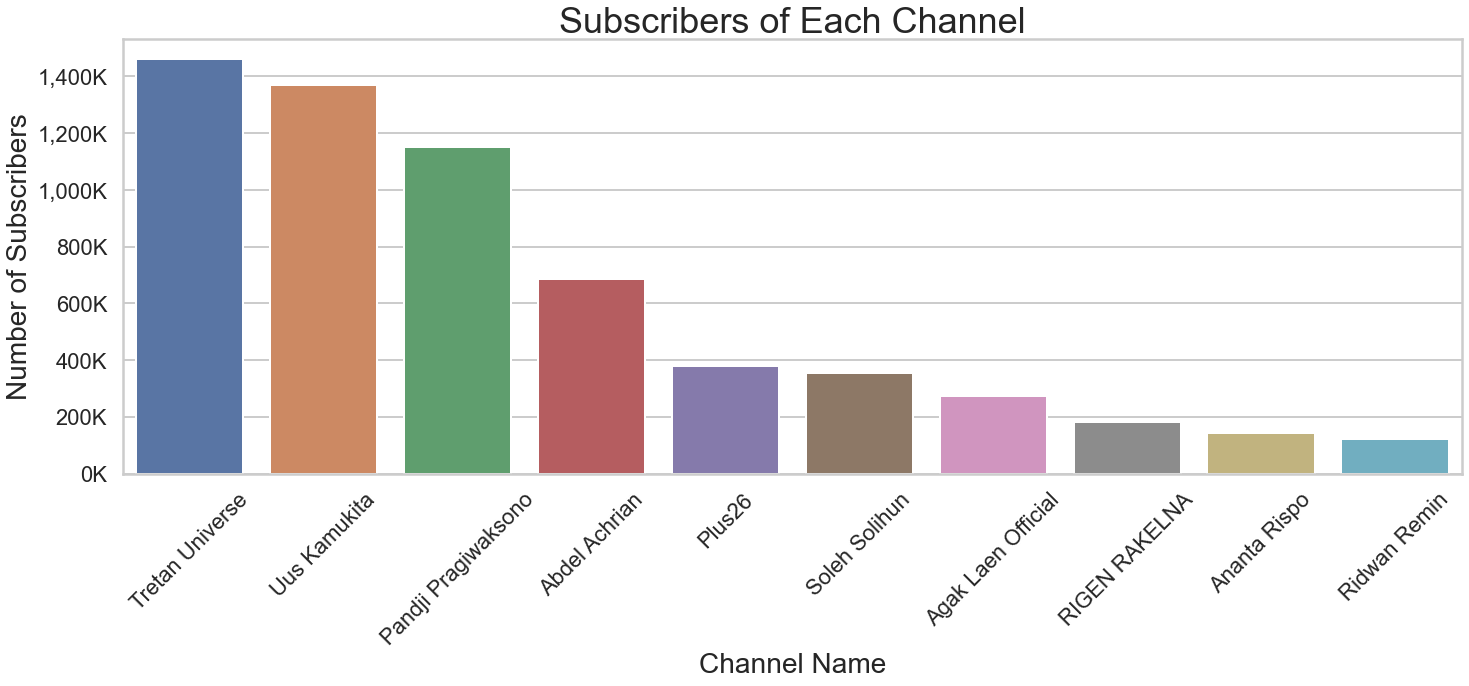

In [342]:
ax = sns.barplot(x = 'channelName', y= 'subscribers', data = chan_df.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_title('Subscribers of Each Channel')
ax.set_ylabel('Number of Subscribers')
ax.set_xlabel('Channel Name')
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
plt.savefig('Subscriber.png', bbox_inches='tight')

### Total Views of Each Channel

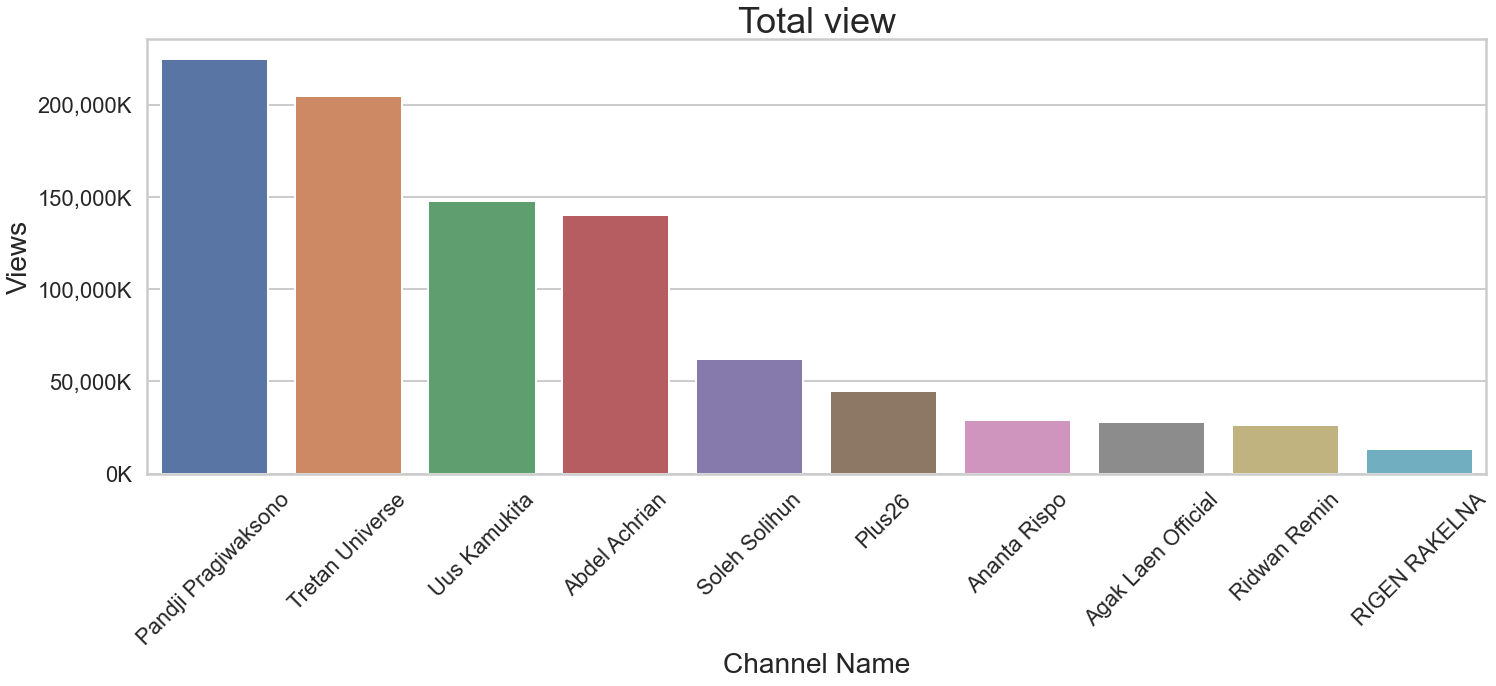

In [339]:
ax = sns.barplot(x = 'channelName', y= 'views', data = chan_df.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_title('Total view')
ax.set_ylabel('Views')
ax.set_xlabel('Channel Name')
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
plt.savefig('totalView.png', bbox_inches='tight')

### View Distribution of each channel

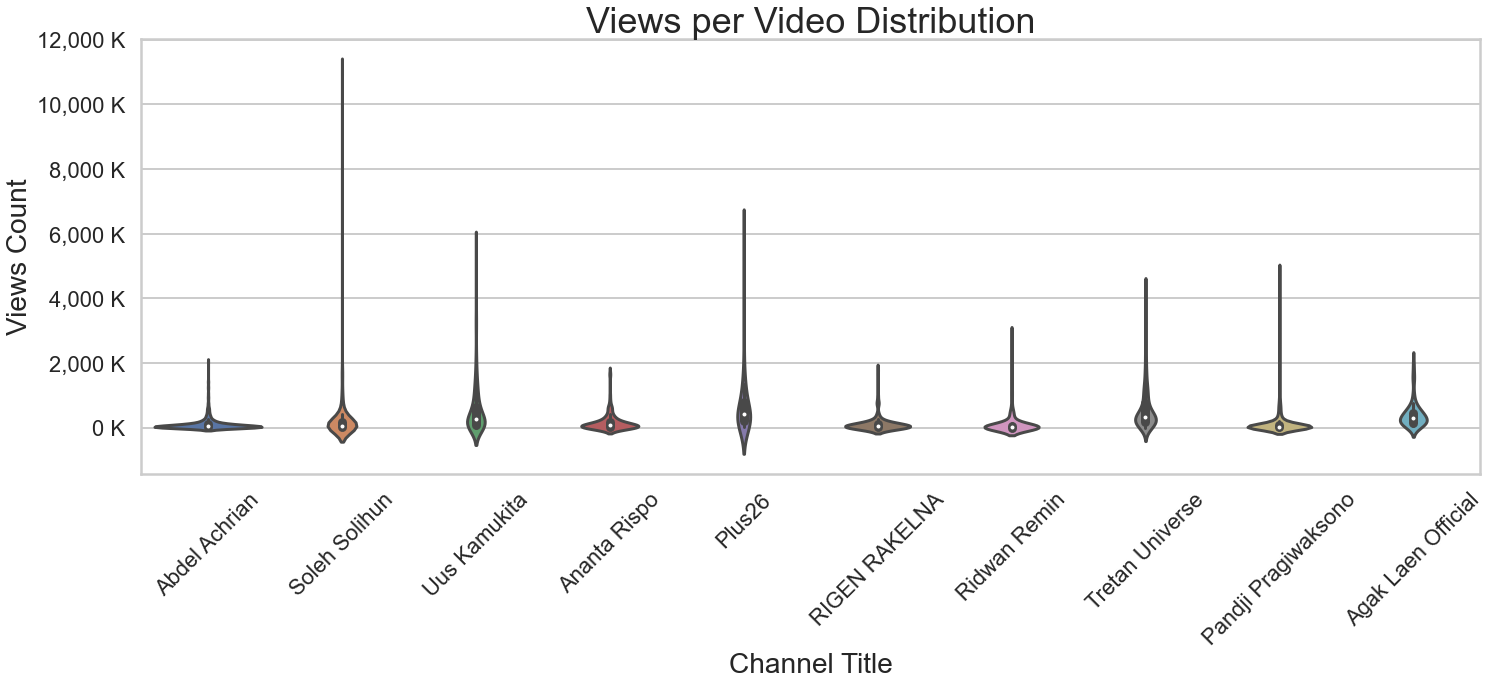

In [320]:
plt.rcParams['figure.figsize'] = (24,8)
ax = sns.violinplot(x= data['channelTitle'], y = data['viewCount'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + ' K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(xlabel = 'Channel Title', ylabel = 'Views Count', title = 'Views per Video Distribution')
plt.savefig('viewDistribution.png', bbox_inches='tight')

From the graph we can say that all channel have almost similar view count distribution below 500.000 views. Some channel have an extraordinary view count that exceed  4 millions view. Soleh solihun's channels has a video that oversteep 10 Milions views. For each channel most viewed video will be showed in the table bellow.

In [281]:
view = data.groupby(['channelTitle'])['viewCount'].max()
maxView = pd.DataFrame(view)

ab = data.sort_values(by = 'channelTitle').reset_index(drop=True)
title = []
for i in range(0, len(ab)):
    for j in range(0, len(maxView)):
        if ab['viewCount'][i] == maxView['viewCount'][j]:
            b = ab['title'][i]
            title.append(b)
maxView['title'] = title
maxView

,viewCount,title
channelTitle,,
Abdel Achrian,2042225.0,WAWANCANDA KAKA DAN BIM BIM SLANK - MENERTAWA...
Agak Laen Official,2004767.0,ADEK ABANG - AIPDA MP. AMBARITA - OKI DIJEMPUT...
Ananta Rispo,1692337.0,Aldi taher bikin Rigen marah marah
Pandji Pragiwaksono,4862853.0,MASALAH PENDIDIKAN KITA
Plus26,5922076.0,ADU MEKANIK HABIB HUSEIN JA’FAR vs BORIS BOKIR...
RIGEN RAKELNA,1777478.0,"TEMENAN 9 TAHUN, AKHIRNYA BISA NGOBROL SERIUS ..."
Ridwan Remin,2889325.0,Rafathar Dibikinin Film sama Raffi Ahmad dan N...
Soleh Solihun,10993654.0,THE SOLEH SOLIHUN INTERVIEW: VINCENT ROMPIES
Tretan Universe,4214329.0,Ngereact Video Reaction Youtube Rewind 2020


### Video Views per channel 

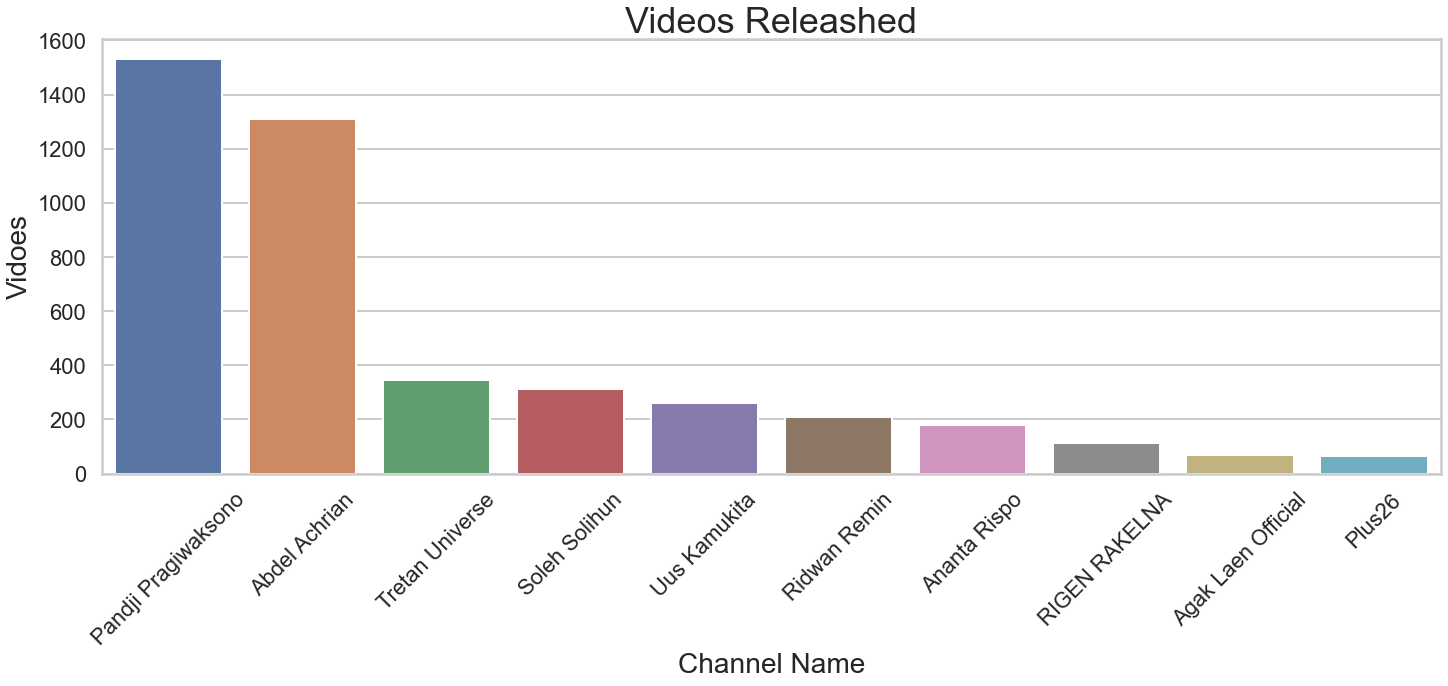

In [340]:
ax = sns.barplot(x = 'channelName', y= 'totalVideos', data = chan_df.sort_values('totalVideos', ascending=False))
ax.set_title('Videos Releashed')
ax.set_ylabel('Vidoes')
ax.set_xlabel('Channel Name')
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
plt.savefig('totalView.png', bbox_inches='tight')

### Video Upload Time

#### Video Uploaded Every Year

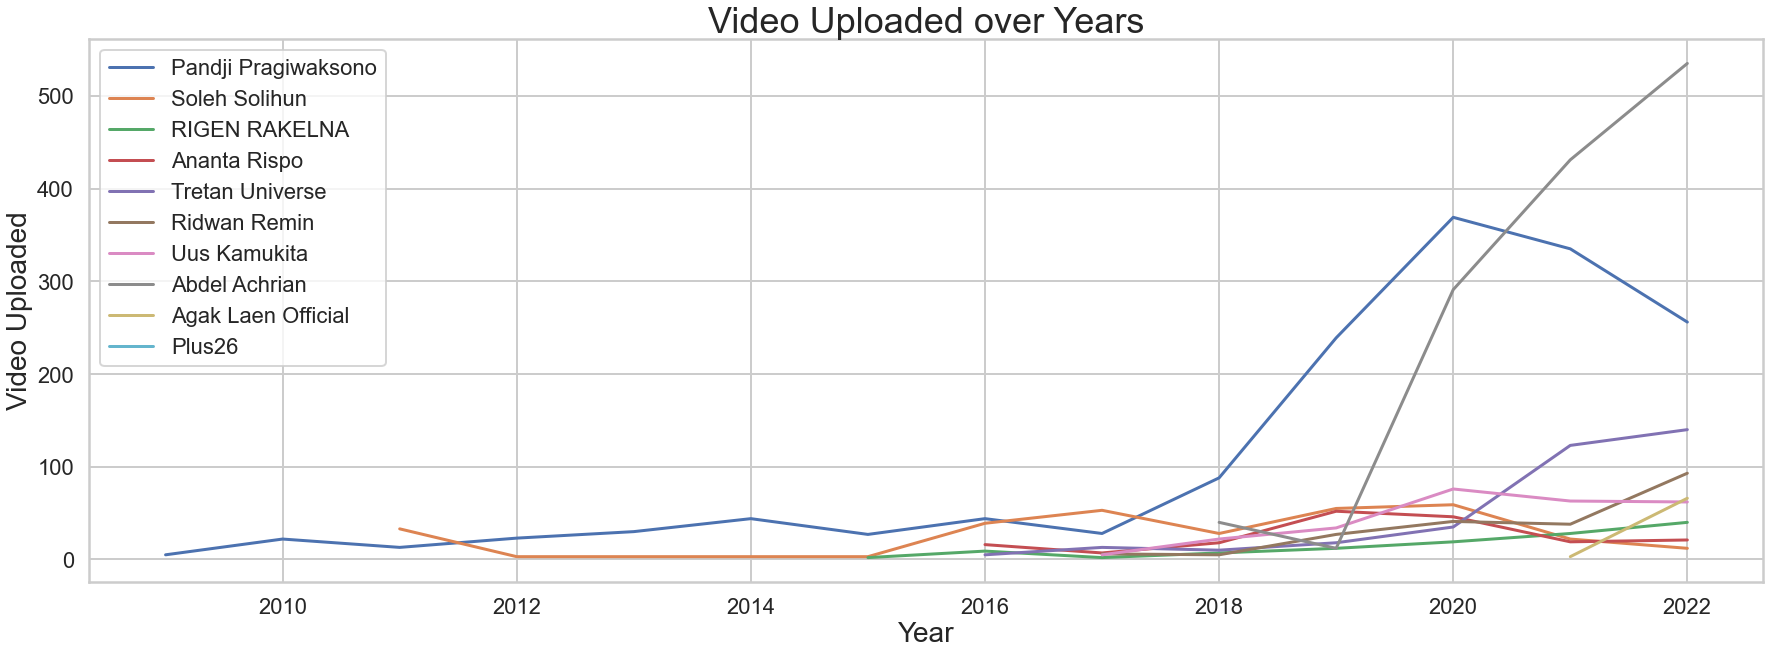

In [345]:
b = data.groupby(['channelTitle','year'])['title'].count()
plot = pd.DataFrame(b)

plot['channel'] = plot.index.get_level_values(0)
plot['year'] = plot.index.get_level_values(1)
plot = plot.reset_index(drop=True)
plot = plot.sort_values(by='year').reset_index(drop=True)


fig, ax = plt.subplots(figsize = (30,10))
key = plot['channel'].unique()
for i in range (0, len(key)):
    ax = sns.lineplot(data = plot[plot['channel'] == key[i]], x = 'year', y = 'title')
ax.legend(key)
ax.set_title('Video Uploaded over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Video Uploaded')
plt.savefig('yearDistribution.png', bbox_inches='tight')

#### Upload Hour Distribution

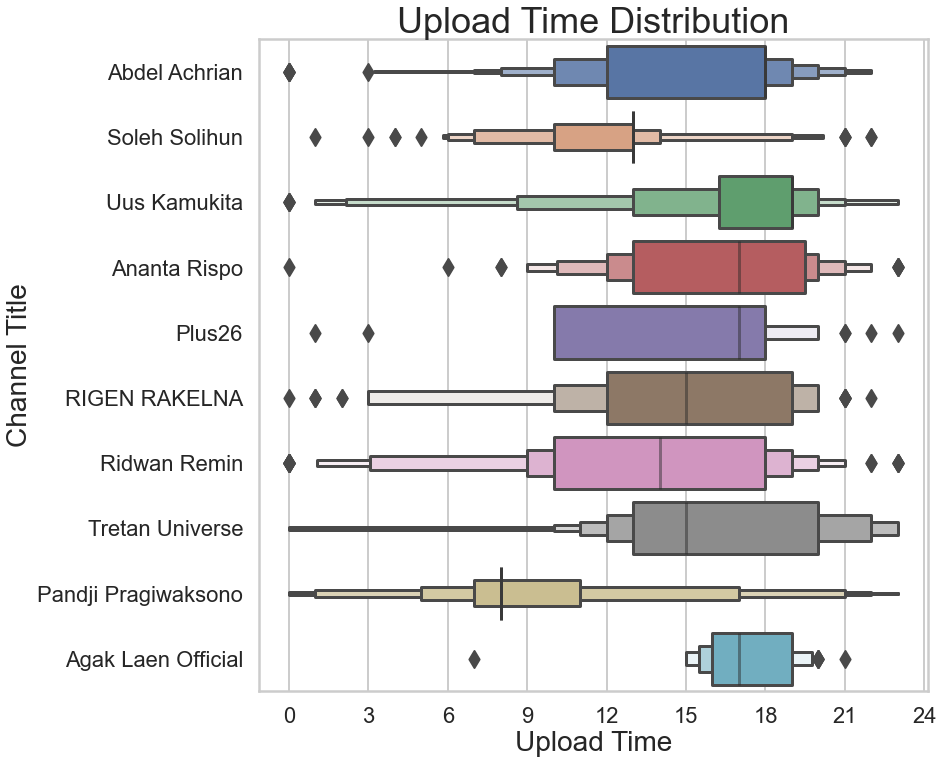

In [317]:
plt.rcParams['figure.figsize'] = (12,12)
ax = sns.boxenplot(data=data, y = 'channelTitle', x = 'hour', )
ax.set(ylabel = 'Channel Title', xlabel = 'Upload Time', title = 'Upload Time Distribution', xticks = [0,3, 6,9,12,15,18,21,24])
plt.savefig('UploadTime.png', bbox_inches='tight')

#### Upload days distribution

In [287]:
productivity = data.groupby([ 'channelTitle','publishedDayName'])['title'].count()
prod_df = pd.DataFrame(productivity)
prod_df['channelName'] = prod_df.index.get_level_values(0)
prod_df['publishDay'] = prod_df.index.get_level_values(1)
prod_df = prod_df.reset_index(drop = True, )
col = prod_df.columns.tolist()
col
col = ['publishDay', 'channelName', 'title']
prod_df = prod_df[col]

added = pd.DataFrame({ 'publishDay' : ['Saturday', 'Friday', 'Tuesday'],
                       'channelName': ['Agak Laen Official', 'Agak Laen Official', 'Plus26'],
                       'title' : [0,0,0]
                     })
prod_df = prod_df.append(added).reset_index(drop = True)

date = []
for i in range (0, len(prod_df)):
    if prod_df['publishDay'][i] == 'Monday':
        ac = 1
    elif prod_df['publishDay'][i] == 'Tuesday':
        ac = 2
    elif prod_df['publishDay'][i] == 'Wednesday':
        ac = 3
    elif prod_df['publishDay'][i] == 'Thursday':
        ac = 4
    elif prod_df['publishDay'][i] == 'Friday':
        ac = 5
    elif prod_df['publishDay'][i] == 'Saturday':
        ac = 6
    else:
        ac = 7
    date.append(ac)


prod_df['count'] = date
prod_df = prod_df.sort_values(by = ['channelName','count']).reset_index(drop=True)


days = []
for i in range (0, len(prod_df)):
    if prod_df['publishDay'][i] == 'Monday':
        ac = 'Mon'
    elif prod_df['publishDay'][i] == 'Tuesday':
        ac = 'Tue'
    elif prod_df['publishDay'][i] == 'Wednesday':
        ac = 'Wed'
    elif prod_df['publishDay'][i] == 'Thursday':
        ac = 'Thur'
    elif prod_df['publishDay'][i] == 'Friday':
        ac = 'Fri'
    elif prod_df['publishDay'][i] == 'Saturday':
        ac = 'Sat'
    else:
        ac = 'Sun'
    days.append(ac)
prod_df['pubDay'] = days

keys = prod_df['channelName'].unique()
per = []
for i in range(0, len(prod_df)):
    for j in range(0, len(keys)):
        if prod_df['channelName'][i] == keys[j]:
            a = prod_df['title'][i]/prod_df[prod_df['channelName'] == keys[j]]['title'].sum()
            per.append(a)
per
prod_df['percentage'] = per

prod_df['percentage'] = prod_df['percentage'] *100
prod_df.head()

C:\Users\Windows10\AppData\Local\Temp\ipykernel_16312\994938078.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prod_df = prod_df.append(added).reset_index(drop = True)


,publishDay,channelName,title,count,pubDay,percentage
0,Monday,Abdel Achrian,192,1,Mon,14.667685
1,Tuesday,Abdel Achrian,189,2,Tue,14.438503
2,Wednesday,Abdel Achrian,196,3,Wed,14.973262
3,Thursday,Abdel Achrian,170,4,Thur,12.987013
4,Friday,Abdel Achrian,191,5,Fri,14.591291


In [288]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor"
        ) 

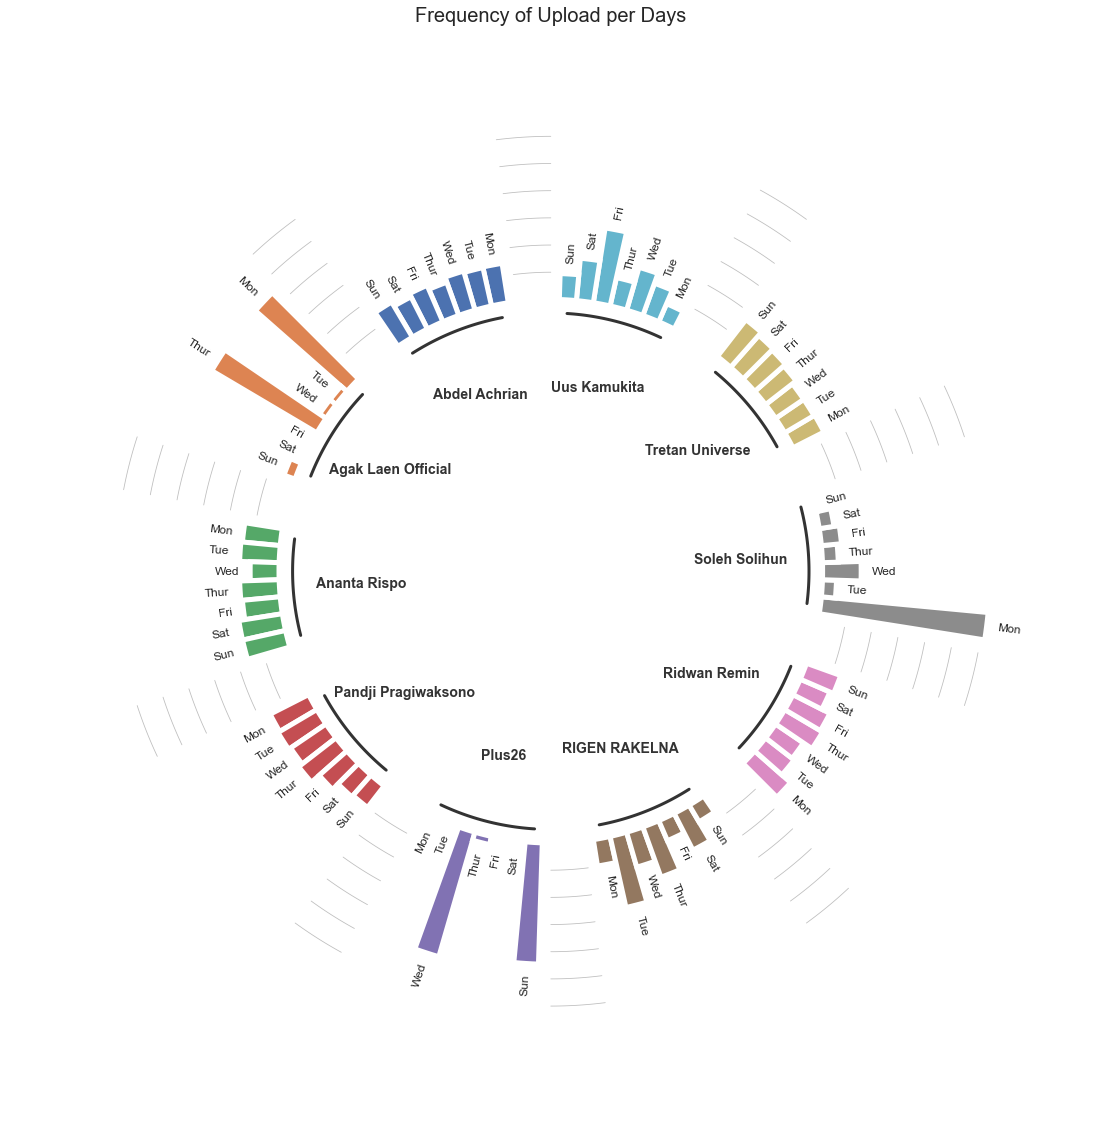

In [316]:
VALUES = prod_df["percentage"].values
LABELS = prod_df['pubDay'].values
GROUP = prod_df["channelName"].values

PAD = 3
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)


# Obtaining the right indexes
offset = 0
IDXS = []
GROUPS_SIZE = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

OFFSET = np.pi / 2

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(50, 20), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Frequency of Upload per Days',fontsize = 20)

#Use different colors for each group!
COLORS = [f'C{i}' for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# Add bars
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=5)

# Add labels
add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

offset = 0 
for group, size in zip(keys, GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -30, group, color="#333333", fontsize=14, 
        fontweight="bold", ha="center", va="center"
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [10] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [30] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [50] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)
   
    
    offset += size + PAD
plt.savefig('FrequencyUploaded.png', bbox_inches='tight')

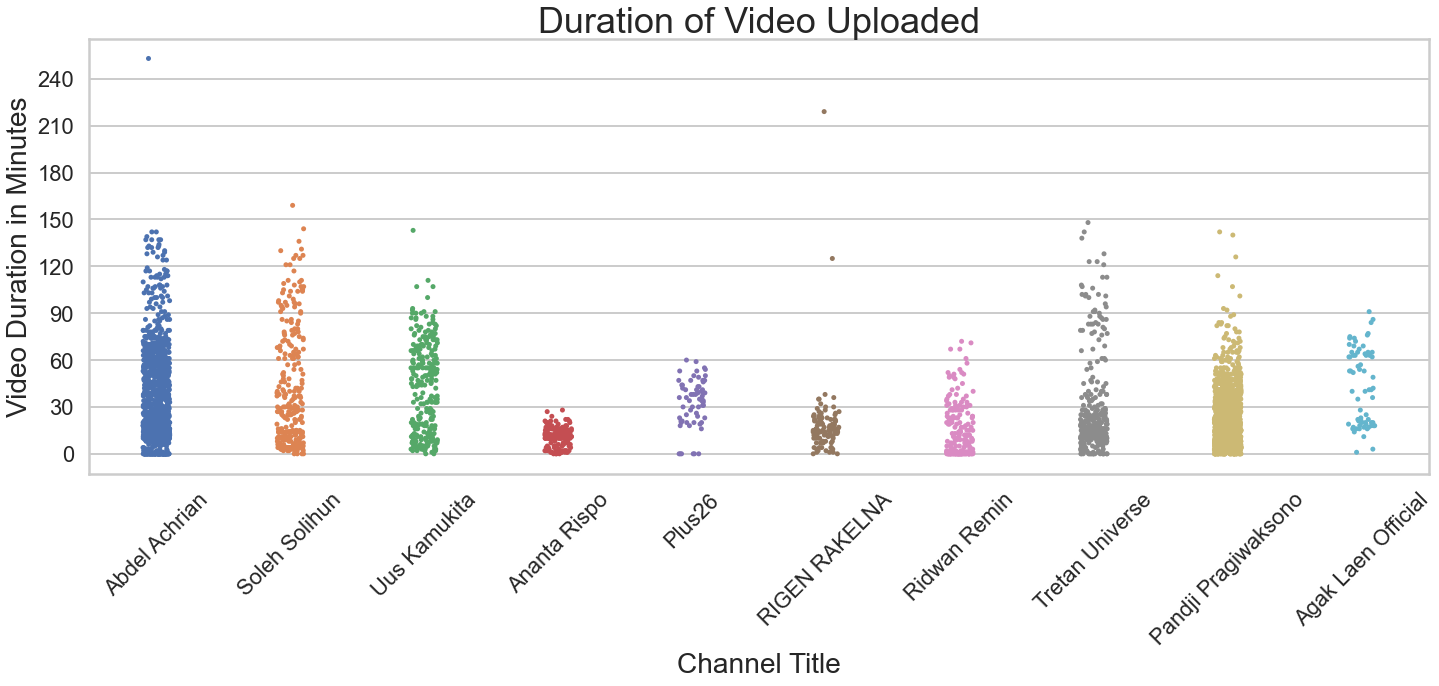

In [321]:
plt.rcParams['figure.figsize'] = (24,8)
ax = sns.stripplot(x= data['channelTitle'], y = data['durationMins'])
ax.set(xlabel = 'Channel Title', ylabel = 'Video Duration in Minutes', title = 'Duration of Video Uploaded', yticks=[0, 30,60,90,120, 150, 180, 210,240])
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
plt.savefig('DurationDistribution.png', bbox_inches='tight')